### Задача
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import seaborn as sns

Считаем данные и посмотрим на них.

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col=0)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 127018 entries, 1 to 127018
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB
None


,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [5]:
df.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [9]:
df.purchase.unique()

array([0, 1])

In [10]:
df.experimentVariant.unique()

array([1, 0])

### A/A-тест

  0%|          | 0/1000 [00:00<?, ?it/s]

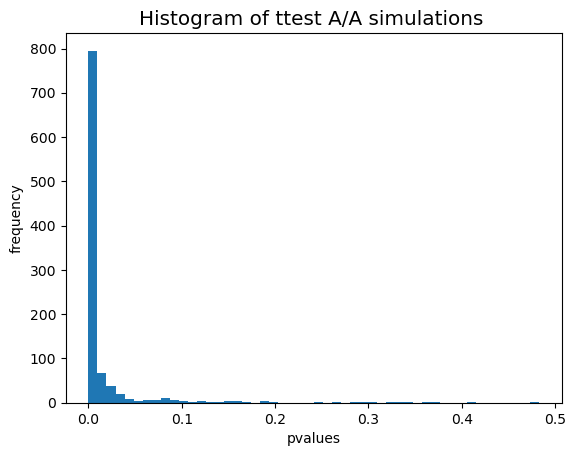

0.93

In [13]:
simulations = 1000
n_s = 1000 # размер подвыборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.loc[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df.loc[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False).pvalue) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Получили, что в большинстве случаев, A/A тест показывает различия, значит действительно что-то не так со сплит-системой.   
Посмотрим как распределяется доля покупок в разных версиях приложения.

In [15]:
df1 = df.groupby(['experimentVariant', 'version'])\
        .purchase.value_counts(normalize=True).rename("perc").reset_index()
df1

,experimentVariant,version,purchase,perc
0,0,v2.8.0,0,0.999007
1,0,v2.8.0,1,0.000993
2,0,v2.9.0,0,0.925342
3,0,v2.9.0,1,0.074658
4,0,v3.7.4.0,0,0.940057
5,0,v3.7.4.0,1,0.059943
6,0,v3.8.0.0,0,0.942396
7,0,v3.8.0.0,1,0.057604
8,1,v2.8.0,0,0.954394
9,1,v2.8.0,1,0.045606


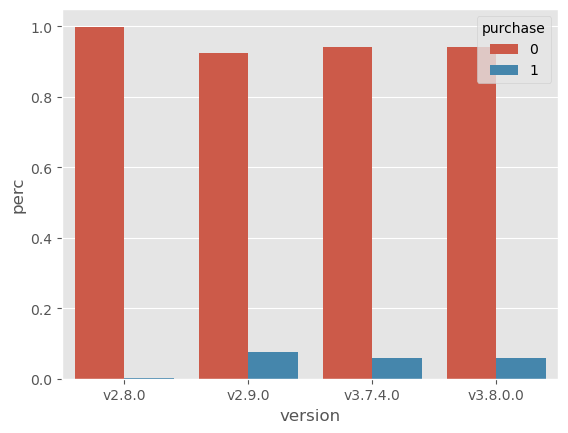

In [17]:
sns.barplot(data=df1.loc[df1.experimentVariant == 0], x = 'version', y = 'perc', hue = 'purchase');

По графику видно, что на версии 2.8.0 что-то пошло не так. 

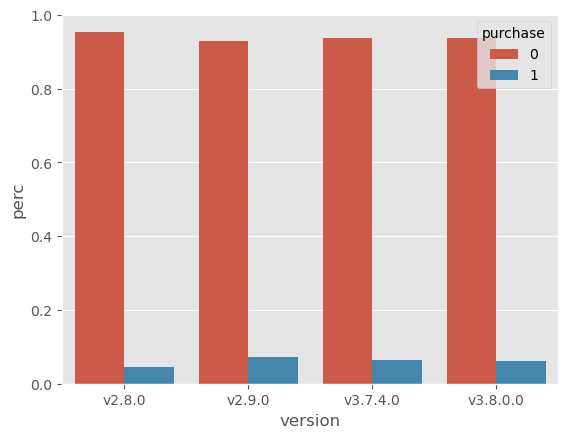

In [18]:
sns.barplot(data=df1.loc[df1.experimentVariant == 1], x = 'version', y = 'perc', hue = 'purchase');

### A/A-тест на данных без поломки

Еще раз проведем симуляцию A/A-теста, но уже без учета данных из версии приложения 2.8.0.

  0%|          | 0/1000 [00:00<?, ?it/s]

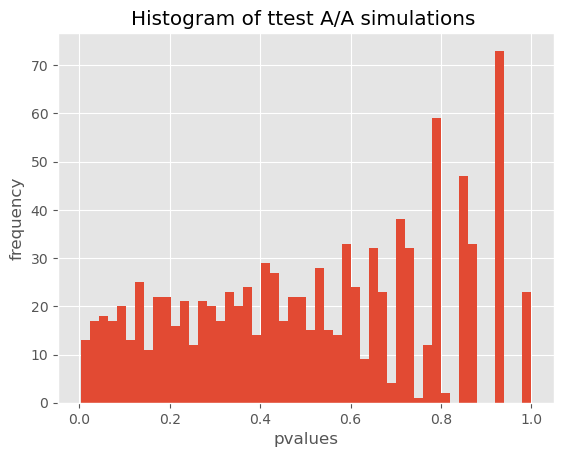

0.039

In [20]:
df = df.loc[df.version != 'v2.8.0']
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.loc[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df.loc[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### Выводы

Для версии приложения 2.8.0 сплит система сработала некорректно и в 1й вариант эксперимента распределила существенно меньше пользователей с покупками, чем во 2й вариант. После удаления этой версии, A/A-тест сходится.  